# Predicting CO2 Emissions in Rwanda

Link: https://www.kaggle.com/competitions/playground-series-s3e20/

The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

The objective of this challenge is to create a machine learning models using open-source CO2 emissions data from Sentinel-5P satellite observations to predict future carbon emissions.

These solutions may help enable governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.
Acknowledgements

We acknowledge Carbon Monitor for the use of the GRACED dataset, and special thanks Darius Moruri from Zindi for his work in preparing the dataset and starter notebooks.

## Dataset Description

The objective of this challenge is to create machine learning models that use open-source emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

Approximately 497 unique locations were selected from multiple areas in Rwanda, with a distribution around farm lands, cities and power plants. The data for this competition is split by time; the years 2019 - 2021 are included in the training data, and your task is to predict the CO2 emissions data for 2022 through November.

Seven main features were extracted weekly from Sentinel-5P from January 2019 to November 2022. Each feature (Sulphur Dioxide, Carbon Monoxide, etc) contain sub features such as column_number_density which is the vertical column density at ground level, calculated using the DOAS technique. You can read more about each feature in the below links, including how they are measured and variable definitions. You are given the values of these features in the test set and your goal to predict CO2 emissions using time information as well as these features.

   * Sulphur Dioxide - COPERNICUS/S5P/NRTI/L3_SO2
   * Carbon Monoxide - COPERNICUS/S5P/NRTI/L3_CO
   * Nitrogen Dioxide - COPERNICUS/S5P/NRTI/L3_NO2
   * Formaldehyde - COPERNICUS/S5P/NRTI/L3_HCHO
   * UV Aerosol Index - COPERNICUS/S5P/NRTI/L3_AER_AI
   * Ozone - COPERNICUS/S5P/NRTI/L3_O3
   * Cloud - COPERNICUS/S5P/OFFL/L3_CLOUD


In [2]:
!pip install pytorch-forecasting[mqf2] -qU

In [3]:
import os
import copy
import pickle
import logging
import re
import time
from typing import List, Optional, Tuple, Any, Union
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from IPython.display import display

from torch.utils.data import DataLoader
from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, RMSE, MQF2DistributionLoss
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Read data

In [4]:
# The training data consists of records from 2019 to 2021 for 487 different localizations
df = pd.read_csv("data/train.csv")    
df["emission_log"] = np.log(df["emission"])
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['week_no'].astype(str) + '-1', format='%Y-%W-%w') 
df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,emission_log,date
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,1.322021,2018-12-31
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,1.392569,2019-01-07
2,ID_-0.510_29.290_2019_02,

In [5]:
# The test data consists of records from 2022 for 487 different localizations
test_df = pd.read_csv("data/test.csv")    
test_df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.561522,829937.000000,-100.113785,33.696957,-133.047562,33.779572,0.112175,2.374888,0.269846,227.193100,0.485340,-100.113785,33.696957,-133.047562,33.779572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.485129,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,15.600607,-140.529848,28.896124,0.000157,0.037641,1688.656342,2814.309683,829652.957598,26.072167,25.189549,-142.612636,28.318923,0.000048,1.117653e-05,0.000037,0.000093,7311.869141,-1.416309,0.036769,829736.125000,76.239196,15.600607,-140.529848,28.896124,0.000123,0.957096,0.000058,0.000000,28.896124,-140.529848,15.600607,76.239196,-0.823662,829753.051343,-0.009998,34.745542,-139.171039,30.405075,0.112643,2.537305,0.290184,228.489219,0.515679,-0.009998,34.745542,-139.171039,30.405075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711262,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,39.889060,-136.908976,30.054682,0.000053,0.037795,2629.692089,3233.654973,829589.971617,14.881259,40.833582,-143.949340,26.760219,0.000055,1.679787e-05,0.000038,0.000109,8

# Data overview

In [6]:
overview_train = df.groupby(["latitude", "longitude"])["ID_LAT_LON_YEAR_WEEK"].count()#.nunique()
overview_test = test_df.groupby(["latitude", "longitude"])["ID_LAT_LON_YEAR_WEEK"].count()#.nunique()
n_locations = len(overview_train)

print(f"There are {n_locations} different locations")
print("159 time data points in the training set and 49 time data points in the testing set.")
print(f"Prediction model ought to predict new 49 datapoints for each of {n_locations}.")

There are 497 different locations
159 time data points in the training set and 49 time data points in the testing set.
Prediction model ought to predict new 49 datapoints for each of 497.


## Average yearly emissions based on localization

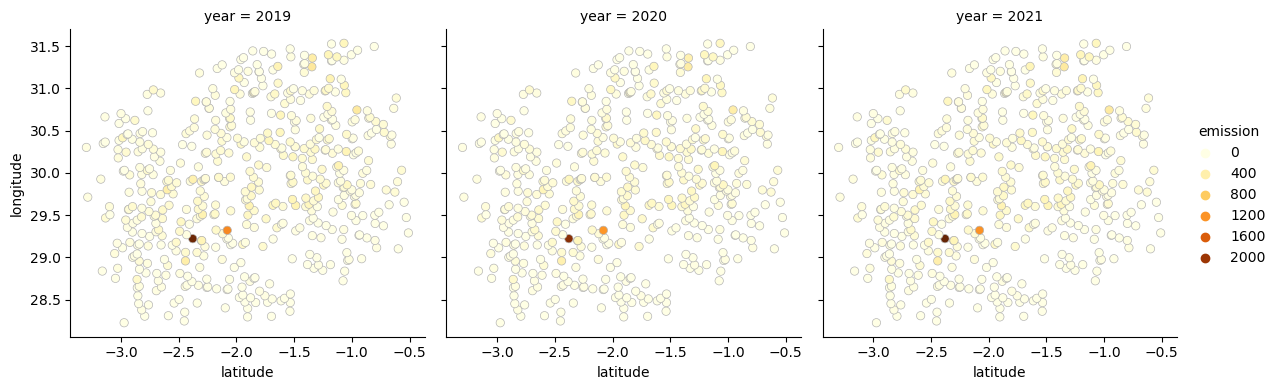

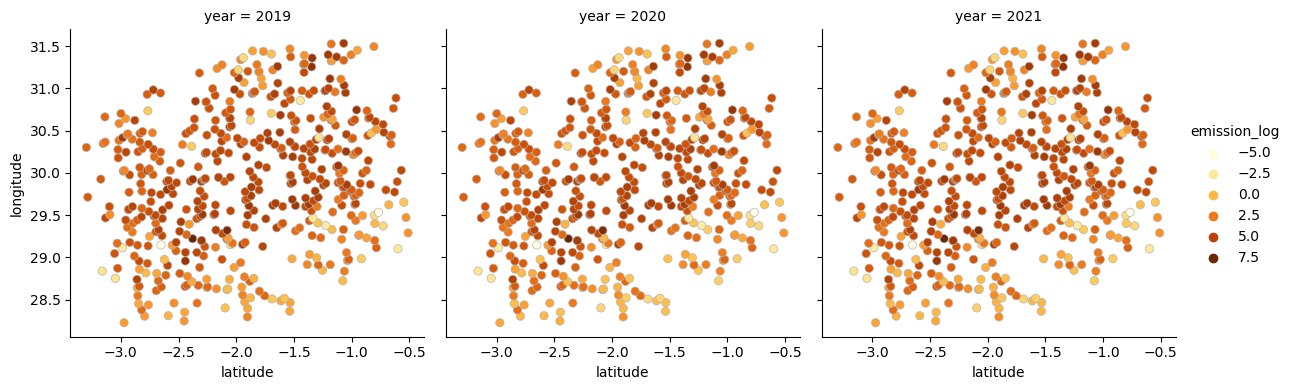

In [7]:
# Emissions are strongly dependent on geographical localization. 

mean_yearly_emissions_df = df.groupby(["longitude", "latitude", "year"])["emission"].mean().reset_index()

sns.relplot(
    data=mean_yearly_emissions_df,
    x="latitude", y="longitude", hue="emission",
    palette="YlOrBr", edgecolor=".7", height=4, col="year"
)
plt.show()

mean_yearly_emissions_log_df = df.groupby(["longitude", "latitude", "year"])["emission_log"].mean().reset_index()
sns.relplot(
    data=mean_yearly_emissions_log_df,
    x="latitude", y="longitude", hue="emission_log",
    palette="YlOrBr", edgecolor=".7",
    height=4, col="year"
)
plt.show()

## Time series overview

In [8]:
def q10(x):
    return x.quantile(0.1)

def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.5)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.9)

mean_emissions_df = df.groupby("date")["emission"].agg(Mean="mean", q_10=q10, q_25=q25, q_50=q50, q_75=q75, q_90=q90)
mean_emissions_df = mean_emissions_df.reset_index()
mean_emissions_df["year"] = mean_emissions_df['date'].dt.year 
mean_emissions_df["week"] = mean_emissions_df['date'].dt.isocalendar().week
mean_emissions_df.head()


,date,Mean,q_10,q_25,q_50,q_75,q_90,year,week
0,2018-12-31,76.739149,1.010258,9.756213,41.193130,96.653946,163.697564,2018,1
1,2019-01-07,82.376350,1.004544,9.947974,43.580956,105.469840,175.971772,2019,2
2,2019-01-14,86.008823,0.989036,10.263707,45.942554,110.093420,185.659272,2019,3
3,2019-01-21,87.903964,1.004204,10.442887,46.912636,112.765480,189.896292,2019,4
4,2019-01-28,89.595095,0.990952,10.481367,47.589570,114.985886,194.491130,2019,5


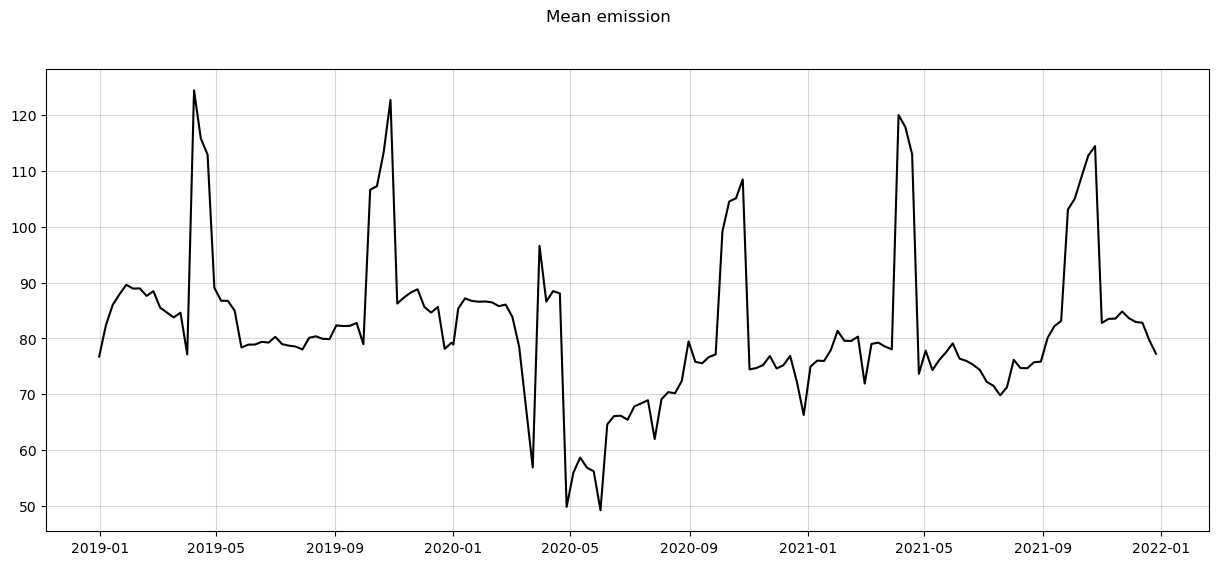

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax.plot(mean_emissions_df.date, mean_emissions_df["Mean"], color = "black")
ax.grid(alpha=0.5)
fig.suptitle("Mean emission")
fig.show()

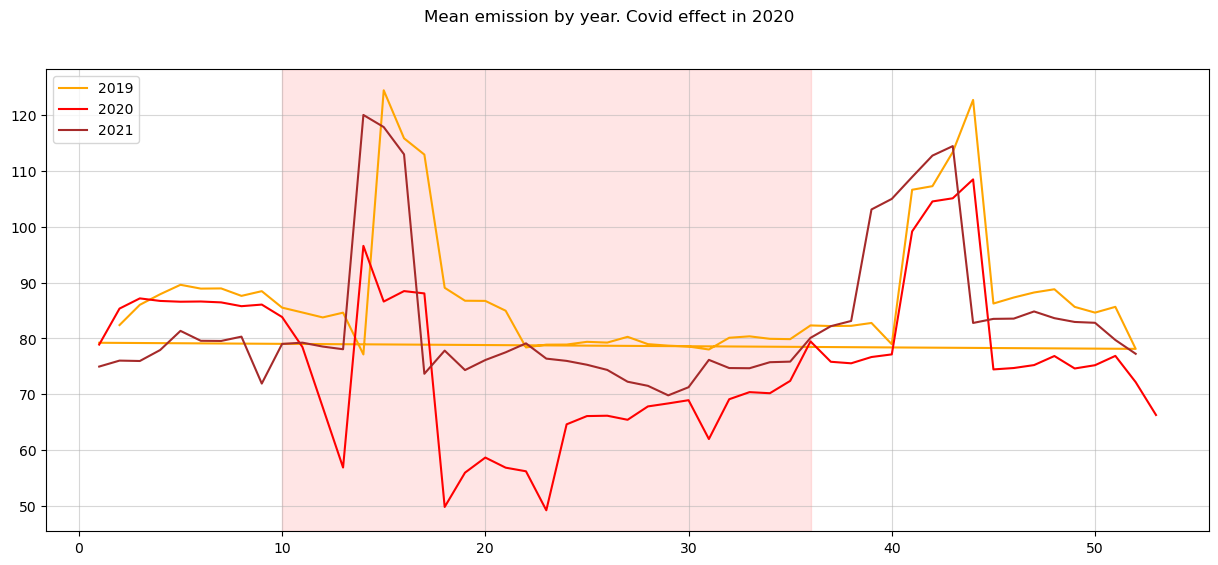

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for year, color in zip([2019, 2020, 2021], ["orange", "red", "brown"]):
    tmp = mean_emissions_df[mean_emissions_df["year"] == year]
    ax.plot(tmp["week"], tmp["Mean"], color = color, label=year)
    
ax.axvspan(10, 36, color="red", alpha=0.1)
ax.legend(loc="upper left")
ax.grid(alpha=0.5)
fig.suptitle("Mean emission by year. Covid effect in 2020")
fig.show()

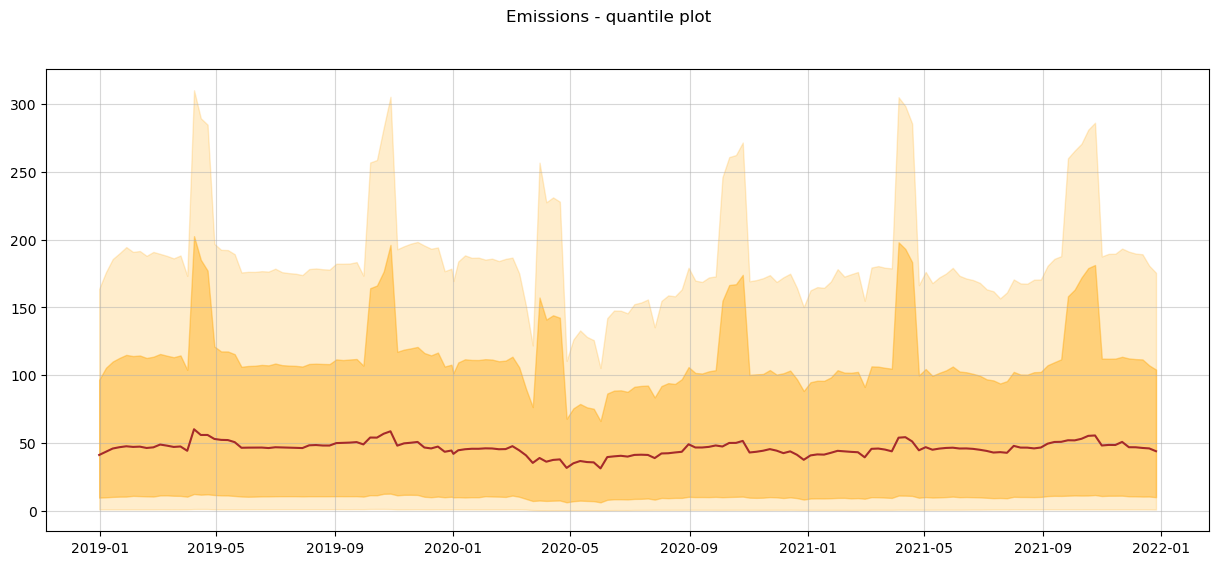

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax.plot(mean_emissions_df.date, mean_emissions_df["q_50"], color = "brown")
ax.fill_between(mean_emissions_df.date, mean_emissions_df['q_10'], mean_emissions_df['q_90'], color='orange', alpha=.2)
ax.fill_between(mean_emissions_df.date, mean_emissions_df['q_25'], mean_emissions_df['q_75'], color='orange', alpha=.4)
ax.grid(alpha=0.5)
fig.suptitle("Emissions - quantile plot")
fig.show()

# Create time series dataset

In [12]:
df.set_index(["latitude", "longitude", "year", "week_no"], inplace=True)

regex_filter = re.compile('.*_(angle|altitude)$')
position_columns = [column for column in df.columns if regex_filter.match(column)]
print(f"\n\nColumns concerning sensor positions:\n{position_columns}")

value_columns = [column for column in df.columns if column not in position_columns]
value_columns = [col for col in value_columns if col not in ["date", "emission_log", "ID_LAT_LON_YEAR_WEEK"]]
print(f"\n\nColumns concerning sensor values:\n{value_columns}")



Columns concerning sensor positions:
['SulphurDioxide_sensor_azimuth_angle', 'SulphurDioxide_sensor_zenith_angle', 'SulphurDioxide_solar_azimuth_angle', 'SulphurDioxide_solar_zenith_angle', 'CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_azimuth_angle', 'CarbonMonoxide_sensor_zenith_angle', 'CarbonMonoxide_solar_azimuth_angle', 'CarbonMonoxide_solar_zenith_angle', 'NitrogenDioxide_sensor_altitude', 'NitrogenDioxide_sensor_azimuth_angle', 'NitrogenDioxide_sensor_zenith_angle', 'NitrogenDioxide_solar_azimuth_angle', 'NitrogenDioxide_solar_zenith_angle', 'Formaldehyde_solar_zenith_angle', 'Formaldehyde_solar_azimuth_angle', 'Formaldehyde_sensor_zenith_angle', 'Formaldehyde_sensor_azimuth_angle', 'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_azimuth_angle', 'UvAerosolIndex_sensor_zenith_angle', 'UvAerosolIndex_solar_azimuth_angle', 'UvAerosolIndex_solar_zenith_angle', 'Ozone_sensor_azimuth_angle', 'Ozone_sensor_zenith_angle', 'Ozone_solar_azimuth_angle', 'Ozone_solar_

In [13]:
columns = ['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no', 'emission']

df.reset_index(inplace=True)
df = df[columns]
df["relative_year"] = df["year"] - df["year"].min()
df["time_idx"] = df["relative_year"] * 53 + df["week_no"]
df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,emission,relative_year,time_idx
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,3.750994,0,0
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,4.025176,0,1
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,4.231381,0,2
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,4.305286,0,3
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,4.347317,0,4


In [14]:
prediction_length = 49
encoder_length = 10
batch_size = 128
max_epochs = 50

training_cutoff = df["time_idx"].max() - prediction_length

training = TimeSeriesDataSet(
            df[lambda x: x.time_idx <= training_cutoff],
            time_idx="time_idx",
            target="emission",
            group_ids= ["latitude", "longitude"],
            time_varying_unknown_reals=["emission"],
            min_encoder_length=encoder_length,
            max_encoder_length=encoder_length,
            min_prediction_length=prediction_length,
            max_prediction_length=prediction_length,
        )

validation = TimeSeriesDataSet.from_dataset(training, df[df["emission"].notna()], predict=True, stop_randomization=True)
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=1)

# Find the best hyperparametres

In [15]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import optuna.logging
optuna_logger = logging.getLogger("optuna")

# need to inherit from callback for this to work
class PyTorchLightningPruningCallbackAdjusted(pl.Callback, PyTorchLightningPruningCallback):
    pass

def optimize_hyperparameters(
    train_dataloaders: DataLoader,
    val_dataloaders: DataLoader,
    model_path: str,
    prediction_length: int = 24,
    max_epochs: int = 20,
    n_trials: int = 100,
    timeout: float = 3600 * 0.5,
    gradient_clip_val_range: Tuple[float, float] = (0.01, 100.0),
    hidden_size_range: Tuple[int, int] = (16, 265),
    learning_rate_range: Tuple[float, float] = (1e-5, 1.0),
    weight_decay_range: Tuple[float, float] = (0.0001, 0.01),
    backcast_loss_ratio_range: Tuple[float, float] = (0.0, 0.05),    
    use_learning_rate_finder: bool = True,
    log_dir: str = "lightning_logs",
    study: optuna.Study = None,
    verbose: Union[int, bool] = None,
    pruner: optuna.pruners.BasePruner = optuna.pruners.SuccessiveHalvingPruner(),
    **kwargs,
) -> optuna.Study:

    logging_level = {
        None: optuna.logging.get_verbosity(),
        0: optuna.logging.WARNING,
        1: optuna.logging.INFO,
        2: optuna.logging.DEBUG,
    }
    optuna_verbose = logging_level[verbose]
    optuna.logging.set_verbosity(optuna_verbose)
 
     # need a deepcopy of loss as it will otherwise propagate from one trial to the next
    loss = kwargs.get("loss", MQF2DistributionLoss(prediction_length=prediction_length)) 
    
    # create objective function
    def objective(trial: optuna.Trial) -> float:

        checkpoint_callback = ModelCheckpoint(
            dirpath=os.path.join(model_path, "trial_{}".format(trial.number)), 
            filename="{epoch}",
            monitor="val_loss"
        )

        learning_rate_callback = LearningRateMonitor()
        logger = TensorBoardLogger(log_dir, name="optuna", version=trial.number)
        gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
        kwargs["loss"] = copy.deepcopy(loss)
  
        trainer = pl.Trainer(
                max_epochs=max_epochs,
                accelerator="auto",
                gradient_clip_val=gradient_clip_val,
                callbacks=[
                    learning_rate_callback,
                    checkpoint_callback,
                    PyTorchLightningPruningCallbackAdjusted(trial, monitor="val_loss"),
                ],
                logger=logger,
                enable_progress_bar=optuna_verbose < optuna.logging.INFO,
                enable_model_summary=[False, True][optuna_verbose < optuna.logging.INFO],
            )        
    
        
        # create model
        model = NHiTS.from_dataset(
            train_dataloaders.dataset,
            weight_decay=trial.suggest_uniform("weight_decay", *weight_decay_range),
            backcast_loss_ratio=0,
            hidden_size= trial.suggest_int("hidden_size", *hidden_size_range, log=True),
            optimizer="AdamW",
            log_interval=-1
        )             
     
        # find good learning rate
        if use_learning_rate_finder:
            lr_trainer = pl.Trainer(
                gradient_clip_val=gradient_clip_val,
                accelerator="auto",
                logger=False,
                enable_progress_bar=False,
                enable_model_summary=False,
            )
            tuner = Tuner(lr_trainer)
            res = tuner.lr_find(
                model,
                train_dataloaders=train_dataloaders,
                val_dataloaders=val_dataloaders,
                early_stop_threshold=10000,
                min_lr=learning_rate_range[0],
                num_training=100,
                max_lr=learning_rate_range[1],
            )

            loss_finite = np.isfinite(res.results["loss"])
            if loss_finite.sum() > 3:  # at least 3 valid values required for learning rate finder
                lr_smoothed, loss_smoothed = sm.nonparametric.lowess(
                    np.asarray(res.results["loss"])[loss_finite],
                    np.asarray(res.results["lr"])[loss_finite],
                    frac=1.0 / 10.0,
                )[min(loss_finite.sum() - 3, 10) : -1].T
                optimal_idx = np.gradient(loss_smoothed).argmin()
                optimal_lr = lr_smoothed[optimal_idx]
            else:
                optimal_idx = np.asarray(res.results["loss"]).argmin()
                optimal_lr = res.results["lr"][optimal_idx]
            optuna_logger.info(f"Using learning rate of {optimal_lr:.3g}")
            model.hparams.learning_rate = trial.suggest_uniform("learning_rate", optimal_lr, optimal_lr)
        else:
            model.hparams.learning_rate = trial.suggest_loguniform("learning_rate", *learning_rate_range)

        trainer.fit(model, train_dataloaders=train_dataloaders, val_dataloaders=val_dataloaders)

        return trainer.callback_metrics["val_loss"].item()

    if study is None:
        study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    return study

study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=max_epochs,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(12, 32),
    learning_rate_range=(0.0001, 0.1),
    weight_decay_range=(0.000001, 0.001),
    backcast_loss_ratio_range=(0.0, 0.001),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,  
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

# Train the model

In [16]:
def train_nhist_model(train_dataloader: DataLoader, val_dataloader: DataLoader, 
                      max_epochs: int,
                      gradient_clip_val: float,
                      hidden_size: int,
                      learning_rate: float, 
                      weight_decay: float = 0.0,
                      backcast_loss_ratio: float = 0.0,
                      model_path = "nhits"
                     ):
    
    
    checkpoint_callback = ModelCheckpoint(dirpath=model_path, filename="{epoch}", monitor="val_loss")
        
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="cpu",
        enable_model_summary=True,
        gradient_clip_val=gradient_clip_val,
        callbacks=[early_stop_callback, checkpoint_callback],
        limit_train_batches=128,
        enable_checkpointing=True,
    )

    net = NHiTS.from_dataset(
        training,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        backcast_loss_ratio=backcast_loss_ratio,
        hidden_size=hidden_size,
        log_interval=-1,
        log_val_interval=-1,
        optimizer="AdamW",
        loss=MQF2DistributionLoss(prediction_length=prediction_length),
    )

    trainer.fit(
        net,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    return net, trainer


In [17]:
hparams = {'gradient_clip_val': 0.10297940472156679, 
           'weight_decay': 0.00011533536981789224,
           'backcast_loss_ratio': 0, 
           'hidden_size': 4,
           'learning_rate': 0.005495408738576245} 

model, trainer = train_nhist_model(train_dataloader, val_dataloader, max_epochs=max_epochs, **hparams)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

INFO: 
  | Name            | Type                 | Params
---------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 9.9 K 
1 | logging_metrics | ModuleList           | 0     
2 | embeddings      | MultiEmbedding       | 0     
3 | model           | NHiTS                | 1.3 K 
---------------------------------------------------------
11.2 K    Trainable params
0         Non-trainable params
11.2 K    Total params
0.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Evaluate

MAE loss: 15.037544250488281	RMSE loss: 39.352447509765625


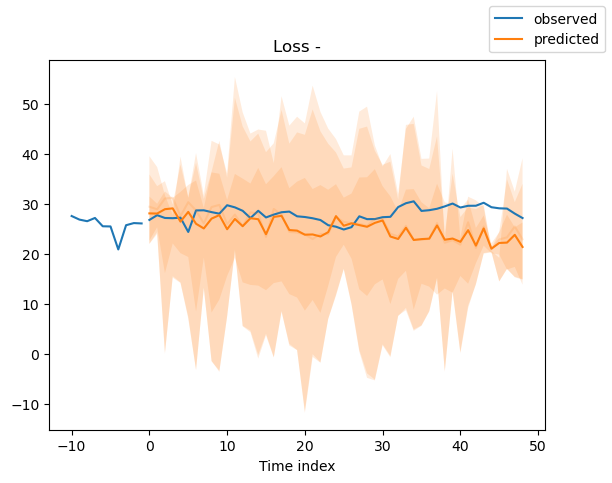

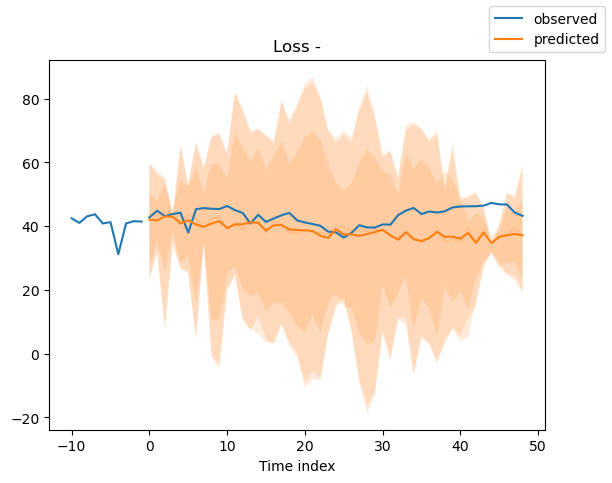

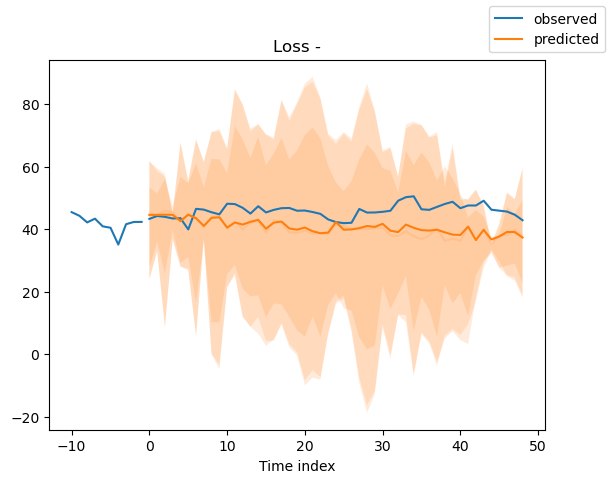

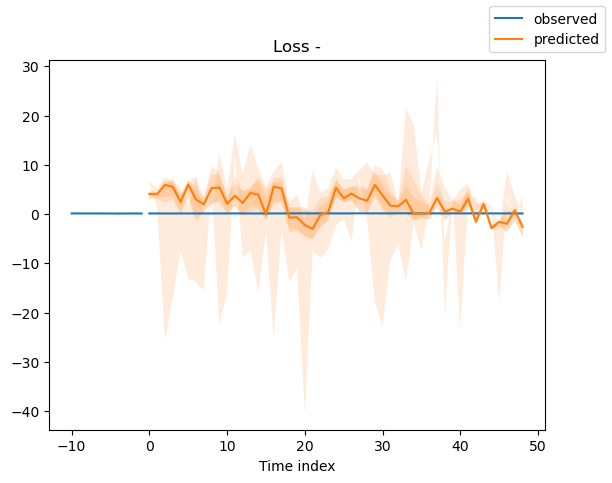

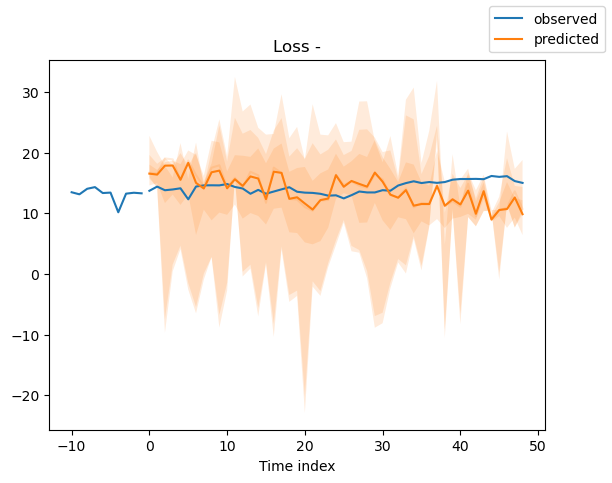

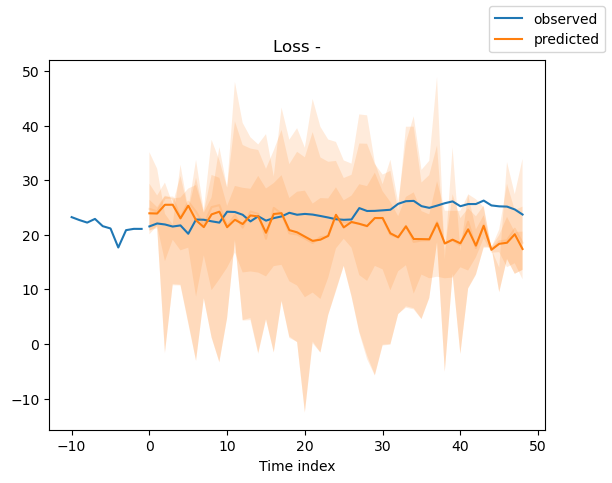

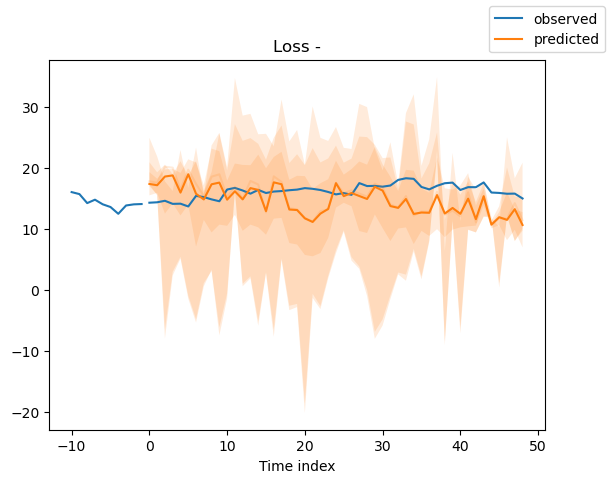

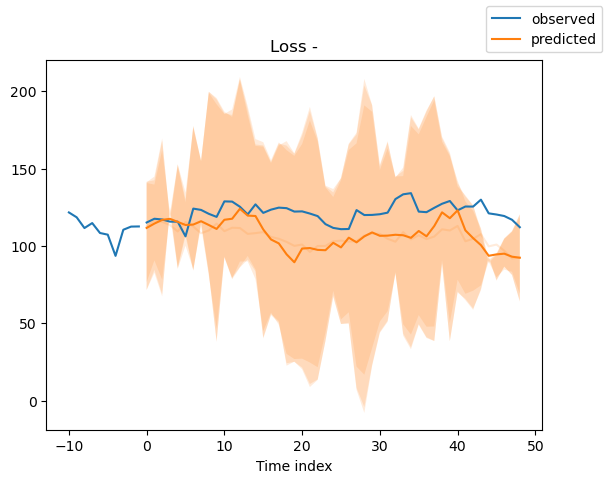

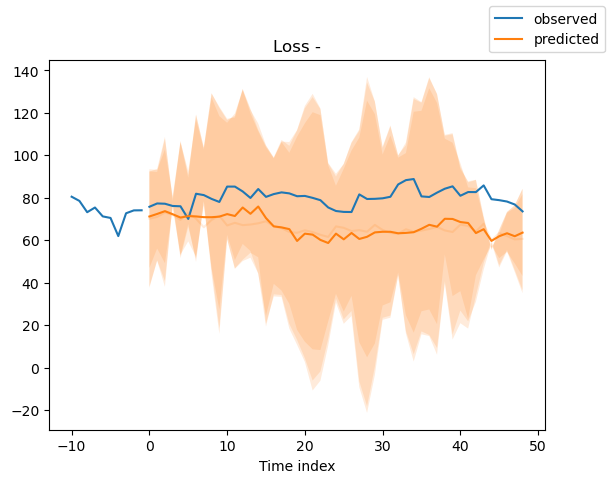

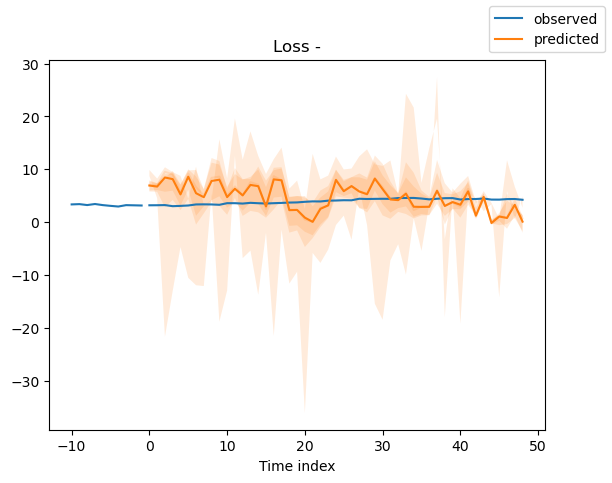

In [18]:
mae_loss = MAE()
rmse_loss = RMSE()
res_dict = dict()

predictions = model.predict(val_dataloader, return_y=True)
mae = float(mae_loss(predictions.output, predictions.y))
rmse = float(rmse_loss(predictions.output, predictions.y))
print(f"MAE loss: {mae}\tRMSE loss: {rmse}")

raw_predictions = model.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

# Predict on test dataset

In [19]:
# select last 49 weeks from data (max_encoder_length is 49)
past_data = df[df["time_idx"] > df["time_idx"].max()-prediction_length]
past_data

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,emission,relative_year,time_idx
110,ID_-0.510_29.290_2021_04,-0.510,29.290,2021,4,4.161754,2,110
111,ID_-0.510_29.290_2021_05,-0.510,29.290,2021,5,4.221930,2,111
112,ID_-0.510_29.290_2021_06,-0.510,29.290,2021,6,4.178392,2,112
113,ID_-0.510_29.290_2021_07,-0.510,29.290,2021,7,4.149280,2,113
114,ID_-0.510_29.290_2021_08,-0.510,29.290,2021,8,4.253003,2,114
...,...,...,...,...,...,...,...,...
79018,ID_-3.299_30.301_2021_48,-3.299,30.301,2021,48,29.404171,2,154
79019,ID_-3.299_30.301_2021_49,-3.299,30.301,2021,49,29.186497,2,155
79020,ID_-3.299_30.301_2021_50,-3.299,30.301,2021,50,29.131205,2,156
79021,ID_-3.299_30.301_2021_51,-3.299,30.301,2021,51,28.125792,2,157


In [20]:
# The testing data consists of records from the first 49 weeks of 2022 for 487 different localizations
test_df = pd.read_csv("data/test.csv")    

test_df["relative_year"] = test_df["year"] - 2019
test_df["time_idx"] = test_df["relative_year"] * 53 + test_df["week_no"]

test_df = pd.concat([past_data, test_df])
test_df = test_df[["ID_LAT_LON_YEAR_WEEK", 'latitude', 'longitude', 'year', 'week_no', 'time_idx', "emission"]]
test_df = test_df.sort_values(["latitude", "longitude", "time_idx"]).reset_index(drop=True)
test_df["emission"].fillna(method='ffill', inplace=True)
test_df.tail(60)

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,time_idx,emission
48646,ID_-0.510_29.290_2021_42,-0.51,29.29,2021,42,148,4.565994
48647,ID_-0.510_29.290_2021_43,-0.51,29.29,2021,43,149,4.629182
48648,ID_-0.510_29.290_2021_44,-0.51,29.29,2021,44,150,4.600272
48649,ID_-0.510_29.290_2021_45,-0.51,29.29,2021,45,151,4.652008
48650,ID_-0.510_29.290_2021_46,-0.51,29.29,2021,46,152,4.641428
48651,ID_-0.510_29.290_2021_47,-0.51,29.29,2021,47,153,4.743777
48652,ID_-0.510_29.290_2021_48,-0.51,29.29,2021,48,154,4.736880
48653,ID_-0.510_29.290_2021_49,-0.51,29.29,2021,49,155,4.687898
48654,ID_-0.510_29.290_2021_50,-0.51,29.29,2021,50,156,4.607418
48655,ID_-0.510_29.290_2021_51,-0.51,29.29,2021,51,157,4.470275


In [21]:
new_time_idx =[df["time_idx"].max() + 1+ i for i in range(prediction_length)]

raw_predictions = model.predict(test_df, mode="prediction", return_x=False, return_index=True, )
predictions_df = raw_predictions.index.drop("time_idx", axis=1)
predictions_df["predictions"] = raw_predictions.output.tolist()
predictions_df = predictions_df.explode("predictions")
predictions_df["time_idx"] = new_time_idx * n_locations

# emissions can not be negative
predictions_df.loc[predictions_df["predictions"] < 0, "predictions"] = 0

predictions_df = pd.merge(test_df.drop("emission", axis=1), predictions_df, 
                          left_on=["latitude", "longitude", "time_idx"], 
                          right_on=["latitude", "longitude", "time_idx"])

predictions_df

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,time_idx,predictions
0,ID_-3.299_30.301_2022_00,-3.299,30.301,2022,0,159,26.986609
1,ID_-3.299_30.301_2022_01,-3.299,30.301,2022,1,160,26.14188
2,ID_-3.299_30.301_2022_02,-3.299,30.301,2022,2,161,26.516792
3,ID_-3.299_30.301_2022_03,-3.299,30.301,2022,3,162,26.754335
4,ID_-3.299_30.301_2022_04,-3.299,30.301,2022,4,163,25.937414
...,...,...,...,...,...,...,...
24348,ID_-0.510_29.290_2022_44,-0.510,29.290,2022,44,203,5.034534
24349,ID_-0.510_29.290_2022_45,-0.510,29.290,2022,45,204,3.153325
24350,ID_-0.510_29.290_2022_46,-0.510,29.290,2022,46,205,3.156671
24351,ID_-0.510_29.290_2022_47,-0.510,29.290,2022,47,206,2.94152


In [22]:
predictions_df.rename(columns={"predictions": "emission"}, inplace=True)
predictions_df[["ID_LAT_LON_YEAR_WEEK", "emission"]].to_csv('data/submission.csv', index=False)